# Работа с текстовыми данными (часть 3 – прототип чат бота)

1. Изучите предложенный пример.
2. Модифицируйте предложенный пример под свои пары вопрос-ответ и сформулируйте не менее 5 своих вопросов.
3. Исследуйте работу системы и сделайте выводы о применимости к своему набору данных способов оценки схожести и структурирования информации и текстовых данных.

### Что такое чат-бот?

Чат-бот (англ. chatbot) — это программа, которая имитирует реальный разговор с пользователем. Вы все наверняка посещали веб-сайт, на котором написано «Привет! чем я могу вам помочь», и мы нажимаем на него и начинаем с ним общаться.

Глобально, чат-боты делятся на следующие типы:

- **Декларативные**, или необучаемые боты действуют в соответствии с заложенным в них сценарием.

- **Предиктивные**, или обучаемые чат-боты создаются при помощи комбинации искусственного интеллекта, машинного обучения и технологии обработки естественного языка.

В данной лабораторной работе мы займёмся разработкой первого варианта чат-бота, но с использованием языковой модели.

Мы создадим список возможных вопросов по теме(в нашем случае вопросы абитуриента ВШЭ), а также список возможных ответов на эти вопросы (по парам).

Далее мы смоделируем ситуацию, когда пользователь задаёт какой-то вопрос, мы находим вопрос из нашей "базы", максимально похожий на вопрос пользователя и предлагаем соответвтующий ответ из пары.

In [ ]:
import spacy
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
questions = ["Какие популярные сериалы сейчас доступны на Кинопоиске?",
             "Предоставляются ли субтитры и озвучка на разных языках для сериалов на Кинопоиске?",
             "Сколько стоит подписка на Кинопоиск и какие варианты подписок существуют?",
             "Какие эксклюзивные сериалы доступны только на Кинопоиске?",
             "Какой самый популярный комедийный сериал на Кинопоиске?",
             "Могу ли я просматривать рейтинги и отзывы других зрителей на Кинопоиске?",
             "Какие новые сериалы скоро появятся на Кинопоиске?",
             "Какие новогодние подборки фильмов и сериалов есть на Кинопоиске?",
             "Что посмотреть вместе с детьми для развлечения и отдыха?",
             "Какой был самый популярный фильм на Кинопоиске в 2020 году?"
 ]

answers = [ "На Кинопоиске доступен широкий выбор популярных сериалов, включая как российские, так и зарубежные хиты. Среди них можно выделить такие сериалы, как 'Игра престолов', 'Очень странные дела', 'Чернобыль', 'Мир Дикого Запада', 'Ведьмак', 'Острые козырьки' и многие другие. Регулярно обновляющийся каталог предлагает новинки и классические произведения, которые обязательно найдут своего зрителя.",
            "Да, большинство сериалов на Кинопоиске сопровождаются субтитрами и озвучкой на нескольких языках, включая русский, английский и другие. Это позволяет зрителям выбирать удобный для них способ просмотра, будь то оригинальная звуковая дорожка с русскими субтитрами или русскоязычная озвучка. Субтитры также могут быть полезны для людей с нарушениями слуха.",
            "Подписка на Кинопоиск варьируется в зависимости от выбранного тарифа. Существует несколько вариантов подписок: стандартная подписка, которая дает доступ ко всему контенту, и специальная подписка с дополнительными преимуществами, такими как отсутствие рекламы и возможность скачивания сериалов для офлайн-просмотра. Цены варьируются в зависимости от региона и текущих акций. Более подробную информацию о тарифах можно найти на официальном сайте Кинопоиска.",
            "Кинопоиск предлагает ряд эксклюзивных сериалов, которые недоступны на других платформах. Среди них можно отметить оригинальные проекты, такие как 'Перевал Дятлова', 'Чикатило', 'Гоголь' и другие. Эти сериалы создаются специально для Кинопоиска и являются частью стратегии привлечения новых подписчиков.",
            "Самый популярный комедийный сериал на Кинопоиске может меняться в зависимости от сезона, премьер и общего интереса аудитории. Однако на текущий момент одним из самых популярных комедийных сериалов на платформе считается 'Друзья' ('Friends'). Этот классический ситком продолжает привлекать огромное количество зрителей благодаря своему легкому юмору, харизматичным персонажам и запоминающимся сюжетным линиям. Это веселый и легкий сериал",
            "Да, на Кинопоиске вы можете ознакомиться с рейтингами и отзывами других зрителей. Это поможет вам составить мнение о сериале до начала просмотра и выбрать наиболее интересный контент. Рейтинги формируются на основе оценок пользователей, а отзывы дают более детальную информацию о впечатлениях от просмотра.",
            "Информация о новых сериалах, которые вскоре появятся на Кинопоиске, постоянно обновляется. Чтобы быть в курсе последних новинок, рекомендуется периодически проверять официальные источники, такие как сайт Кинопоиска или его социальные сети. Тем не менее, скоро будет доступен сериал 'Медиатор', это драматический сериал о человеке, который решает конфликты между людьми, используя нестандартные методы. Ожидается, что проект предложит глубокий взгляд на человеческие отношения и психологию.",
            "На Кинопоиске традиционно появляются новогодние подборки фильмов и сериалов, чтобы помочь зрителям выбрать подходящее настроение для праздничных дней. Эти подборки обычно включают как классические новогодние и рождественские фильмы, так и современные комедии, драмы и мультфильмы, связанные с зимними праздниками. Рекомендуем подборку 'Новогодние мюзиклы и музыкальные фильмы', такие как 'Щелкунчик и четыре королевства', 'Ла-Ла Ленд', 'Последний богатырь' и другие, поднимают настроение и заряжают энергией.",
            "Можно посмотреть такие мультфильмы и семейные фильмы, как 'Тайна Коко', 'Холодное сердце', 'Зверополис' и другие. Эти ленты создают атмосферу волшебства и радости.",
            "Самым популярным фильмом на Кинопоиске в 2020 году стал 'Паразиты' (2019) — южнокорейский фильм режиссера Пон Джун-хо. Он получил широкую известность и признание как критиков, так и зрителей по всему миру. Фильм выиграл Оскар в четырех категориях, став первым неанглоязычным фильмом, которому удалось достичь такого успеха.'Паразиты' рассказывает историю бедной корейской семьи, которая постепенно внедряется в жизнь богатой семьи, манипулируя ими ради собственной выгоды. Фильм сочетает в себе элементы триллера, черной комедии и социальной драмы, что делает его уникальным и запоминающимся."
 ]

In [ ]:
# вопрос, который задаём
question = "Какой веселый фильм посмотреть на Кинопоиске?"
questions.append(question)

In [ ]:
questions

['Какие популярные сериалы сейчас доступны на Кинопоиске?',
 'Предоставляются ли субтитры и озвучка на разных языках для сериалов на Кинопоиске?',
 'Сколько стоит подписка на Кинопоиск и какие варианты подписок существуют?',
 'Какие эксклюзивные сериалы доступны только на Кинопоиске?',
 'Какой самый популярный комедийный сериал на Кинопоиске?',
 'Могу ли я просматривать рейтинги и отзывы других зрителей на Кинопоиске?',
 'Какие новые сериалы скоро появятся на Кинопоиске?',
 'Какие новогодние подборки фильмов и сериалов есть на Кинопоиске?',
 'Что посмотреть вместе с детьми для развлечения и отдыха?',
 'Какой был самый популярный фильм на Кинопоиске в 2020 году?',
 'Какой веселый фильм посмотреть на Кинопоиске?']

Используем spacy для лемматизации на русском языке, не забудем убрать знаки препинания, которые не несут для нас полезной информации в данном случае.

In [ ]:
!python -m spacy download ru_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 61.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load('ru_core_news_lg')

In [ ]:
n = len(questions)
text_vectorized = [None] * n
text_lemmatized = [None] * n

for i in range(n):
    text_vectorized[i] = nlp(questions[i]).vector
    text_lemmatized[i] = " ".join([token.lemma_ for token in nlp(questions[i]) if token.pos_ != 'PUNCT'])

In [ ]:
text_lemmatized #посмотрим на получившийся текст

['какой популярный сериал сейчас доступный на кинопоиске',
 'предоставляются ли субтитр и озвучка на разный язык для сериал на кинопоиске',
 'сколько стоить подписка на кинопоиск и какой вариант подписка существовать',
 'какой эксклюзивный сериал доступный только на кинопоиске',
 'какой самый популярный комедийный сериал на кинопоиске',
 'мочь ли я просматривать рейтинг и отзыв других зритель на кинопоиске',
 'какой новый сериал скоро появиться на кинопоиске',
 'какой новогодний подборка фильм и сериал быть на кинопоиске',
 'что посмотреть вместе с ребёнок для развлечение и отдых',
 'какой быть самый популярный фильм на кинопоиске в 2020 год',
 'какой весёлый фильм посмотреть на кинопоиске']

Теперь переведём наши тексты в вектора.

**CountVectorizer** - это функция, которая преобразует текстовые данные в матрицу Bag of Words. Он строит словарь всех уникальных слов в тексте и преобразует каждое предложение в вектор, где каждый элемент вектора представляет счетчик вхождений соответствующего слова в предложение.

**TfidfTransformer** - это класс, который преобразует матрицу Bag of Words в матрицу TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF - это статистическая мера, которая оценивает важность слова в документе, учитывая его частоту встречаемости в документе и обратную частоту встречаемости во всей коллекции документов. Преобразование TF-IDF позволяет учитывать важность слова не только в пределах одного предложения, но и в контексте всего текста.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stop_words)

tk = vectorizer.fit_transform(text_lemmatized)

tk_tfidf = TfidfTransformer().fit_transform(tk)

В библиотеке sklearn есть функция подсчёта расстояния между векторами. В данном случае имеется в виду косинусное расстояние (формулу см. в материалах к семинару 13).

Построим расстояния между вопросом пользователя и уже заготовленными вопросами.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Считаем косинусные расстояния между текстами
tk_dist = cosine_similarity(tk, tk)
tk_tfidf_dist = cosine_similarity(tk_tfidf, tk_tfidf)

text_vectorized_dist = cosine_similarity(text_vectorized, text_vectorized)

А теперь вывевем ответ на вопрос, который максимально похож на тот, что введён пользователем.

In [ ]:
print(question)
max_index = np.argmax(tk_dist[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
На Кинопоиске традиционно появляются новогодние подборки фильмов и сериалов, чтобы помочь зрителям выбрать подходящее настроение для праздничных дней. Эти подборки обычно включают как классические новогодние и рождественские фильмы, так и современные комедии, драмы и мультфильмы, связанные с зимними праздниками. Рекомендуем подборку 'Новогодние мюзиклы и музыкальные фильмы', такие как 'Щелкунчик и четыре королевства', 'Ла-Ла Ленд', 'Последний богатырь' и другие, поднимают настроение и заряжают энергией.


In [ ]:
# проделайте то же самое для матрицы TF-IDF
print(question)
max_index = np.argmax(tk_tfidf_dist[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
На Кинопоиске традиционно появляются новогодние подборки фильмов и сериалов, чтобы помочь зрителям выбрать подходящее настроение для праздничных дней. Эти подборки обычно включают как классические новогодние и рождественские фильмы, так и современные комедии, драмы и мультфильмы, связанные с зимними праздниками. Рекомендуем подборку 'Новогодние мюзиклы и музыкальные фильмы', такие как 'Щелкунчик и четыре королевства', 'Ла-Ла Ленд', 'Последний богатырь' и другие, поднимают настроение и заряжают энергией.


In [ ]:
# проделайте то же самое для текста, векторизованного spaCy
print(question)
max_index = np.argmax(text_vectorized_dist[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
Самый популярный комедийный сериал на Кинопоиске может меняться в зависимости от сезона, премьер и общего интереса аудитории. Однако на текущий момент одним из самых популярных комедийных сериалов на платформе считается 'Друзья' ('Friends'). Этот классический ситком продолжает привлекать огромное количество зрителей благодаря своему легкому юмору, харизматичным персонажам и запоминающимся сюжетным линиям. Это веселый и легкий сериал


### Самостоятельно реализуйте подсчёт Евклидова расстояния между предложениями.

Рассчитайте эту меру для 3 векторных представлений.

In [ ]:
# TO-DO: рассчитать близость между 3 векторыми представлениями с помощью Евклидова расстояния
from sklearn.metrics.pairwise import euclidean_distances

# Считаем Евклидово расстояния между текстами
tk_dist_ = euclidean_distances(tk, tk)
tk_tfidf_dist_ = euclidean_distances(tk_tfidf, tk_tfidf)

text_vectorized_dist_ = euclidean_distances(text_vectorized, text_vectorized)

In [ ]:
print(question)
max_index = np.argmax(tk_dist_[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
Подписка на Кинопоиск варьируется в зависимости от выбранного тарифа. Существует несколько вариантов подписок: стандартная подписка, которая дает доступ ко всему контенту, и специальная подписка с дополнительными преимуществами, такими как отсутствие рекламы и возможность скачивания сериалов для офлайн-просмотра. Цены варьируются в зависимости от региона и текущих акций. Более подробную информацию о тарифах можно найти на официальном сайте Кинопоиска.


In [ ]:
# проделайте то же самое для матрицы TF-IDF
print(question)
max_index = np.argmax(tk_tfidf_dist_[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
Подписка на Кинопоиск варьируется в зависимости от выбранного тарифа. Существует несколько вариантов подписок: стандартная подписка, которая дает доступ ко всему контенту, и специальная подписка с дополнительными преимуществами, такими как отсутствие рекламы и возможность скачивания сериалов для офлайн-просмотра. Цены варьируются в зависимости от региона и текущих акций. Более подробную информацию о тарифах можно найти на официальном сайте Кинопоиска.


In [ ]:
# проделайте то же самое для текста, векторизованного spaCy
print(question)
max_index = np.argmax(text_vectorized_dist_[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
Можно посмотреть такие мультфильмы и семейные фильмы, как 'Тайна Коко', 'Холодное сердце', 'Зверополис' и другие. Эти ленты создают атмосферу волшебства и радости.


### Введём ещё одну меру похожести:

**Коэффициент сходства Жаккара (Jaccard similarity coefficient)** - это метрика, используемая для измерения схожести между двумя множествами. Коэффициент Жаккара определяется как отношение размера пересечения двух множеств к их объединению.

Формула для вычисления коэффициента сходства Жаккара:

$$J(A, B) = \frac{|A ∩ B|}  {|A ∪ B|}$$

где:

$J(A, B)$ - коэффициент сходства Жаккара между множествами A и B.

$|A ∩ B|$ - количество элементов, присутствующих в обоих множествах (размер пересечения).

$|A ∪ B|$ - количество уникальных элементов в обоих множествах (размер объединения).

Коэффициент сходства Жаккара находится в диапазоне от 0 до 1, где 0 означает полное отсутствие сходства (нет общих элементов), а 1 - полное совпадение (множества идентичны).

In [ ]:
jaccard_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        q_tokens_1 = set(text_lemmatized[i].split())
        q_tokens_2 = set(text_lemmatized[j].split())
        jaccard_similarity =  len(q_tokens_1.intersection(q_tokens_2))/len(q_tokens_1.union(q_tokens_2))

        jaccard_matrix[i, j] = jaccard_similarity

In [ ]:
print(question)
max_index = np.argmax(jaccard_matrix[n-1, 0:(n-2)])
print(answers[max_index])

Какой веселый фильм посмотреть на Кинопоиске?
На Кинопоиске традиционно появляются новогодние подборки фильмов и сериалов, чтобы помочь зрителям выбрать подходящее настроение для праздничных дней. Эти подборки обычно включают как классические новогодние и рождественские фильмы, так и современные комедии, драмы и мультфильмы, связанные с зимними праздниками. Рекомендуем подборку 'Новогодние мюзиклы и музыкальные фильмы', такие как 'Щелкунчик и четыре королевства', 'Ла-Ла Ленд', 'Последний богатырь' и другие, поднимают настроение и заряжают энергией.


# Чат-бот с GUI (вопросы о погоде)

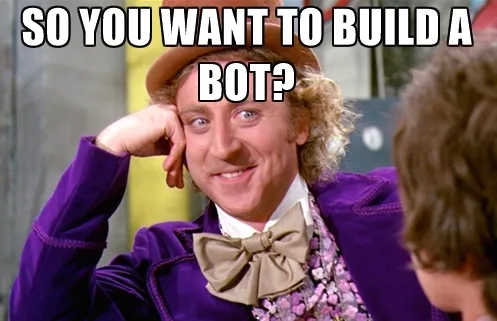

Эта часть не относится к основному заданию, это просто один из вариантов, как можно легко сделать собственного чат-бота, который тянет информацию с определённого сайта по API и способен отвечать на вопросы по теме.

А именно, мы сделаем чат-бота, который может тянуть с сайта openweather.com информацию о погоде в формате json файла и отвечать на вопросы о погоде в данный момент в разных городах.

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import random

nlp = spacy.load("en_core_web_md")
# используем англоязычную модель, так как с сайта информация
# тянется на английском

# не забудьте скачать подходящую модель!

Для того, чтобы брать информацию с сайта openweather.com нам понадобится модуль requests.

Довольно часто для того, чтобы воспользоваться доступом по API, Вам нужно зарегистрироваться на сайте. В нашем случае, вам нужно зарегистрироваться [здесь](https://home.openweathermap.org/), а затем сгенерировать API ключ [здесь](https://home.openweathermap.org/api_keys).

**ВАЖНО**: новый api_key активируется НЕ СРАЗУ, это может занять до 2 часов.

In [ ]:
import requests

api_key = "9e9c32d248154b654e2abf1027bcaeee"
def get_weather(city_name, api_key):
	api_url = "http://api.openweathermap.org/data/2.5/weather?q={}&appid={}".format(city_name, api_key)
	response = requests.get(api_url)
	# нам возвращается целый словарь информации с сайта
	response_dict = response.json()
    # из словаря по ключу извлекаем информацию о погоде на данный момент
	weather = response_dict["weather"][0]["description"]
	if response.status_code == 200:
		return weather
	else:
		# если что-то пойдёт не так, мы получим это сообщение об ошибке
		print(f'[!]ERROR: HTTP {response.status_code} calling [{api_url}]')
		return None

Проверим, как работает эта функция:

In [ ]:
weather = get_weather("Perm", api_key)
weather

'light snow'

Теперь напишем функцию самого чат-бота.

Наш бот будет получать на вход вопрос о погоде в каком-либо городе и сообщать текущий статус.

Для обработки входящих вопросов мы снова воспользуемся "похожестью" между предложениями (косинусное расстояние). Для этого создадим небольшой список возможных вопросов к боту и если входящий вопрос "похож", а на самом деле, расстояние между хотя бы одним из этих предложений больше 0.75, то тогда мы продолжаем обрабатывать запрос. Иначе мы считаем, что пользователь спросил какую-то ерунду и возвращаем сообщение об ошибке и просим переформулировать запрос.

In [ ]:
def chatbot(statement):
    weather = [nlp("Current weather in a city"),
               nlp('What is the weather in a city?'),
               nlp('Tell me the weather in a city')
              ]
    statement = nlp(statement)
    similarity_stat = [sent.similarity(statement)
                       for sent in weather]
    min_similarity = 0.75
    if max(similarity_stat) >= min_similarity:

        for ent in statement.ents:
            if ent.label_ == "GPE": # GeoPolitical Entity
               city = ent.text
               break
            else:
               return "You need to tell me a correct name of a city to check."
        city_weather = get_weather(city, api_key)
        if city_weather is not None:
              return random.choice([f'In {city} the current weather is: {city_weather}',
                                    f'Today it is {city_weather} in {city}',
                                    f'It is {city_weather} in {city}.',
                                    f'It is {city_weather} in lovely {city}. Do you like to go there?'
                                   ])
        else:
              return "Something went wrong! Check your connection."
    else:
        return "Sorry, I don't understand that. Please rephrase your question!"

In [ ]:
response = chatbot("What is the weather in Omsk?")
print(response)

It is clear sky in lovely Omsk. Do you like to go there?


In [ ]:
from ipywidgets import widgets, interact
import ipywidgets as ipw

In [ ]:
style = {'description_width': 'initial'}
layout = {'width': '400px'}

In [ ]:
text_input = widgets.Text(value='', placeholder='Your question:', style=style, layout=layout)
button = widgets.Button(description='Get answer', style={'button_color': 'lightblue'})
output_label = widgets.Label(value='', style=style)

In [ ]:
def on_button_clicked(b):
    output_label.value = chatbot(text_input.value)

button.on_click(on_button_clicked)

In [ ]:
display(button, text_input, output_label)

Button(description='Get answer', style=ButtonStyle(button_color='lightblue'))

Text(value='', layout=Layout(width='400px'), placeholder='Your question:', style=DescriptionStyle(description_…

Label(value='', style=DescriptionStyle(description_width='initial'))

Далее можно продумывать более точные пользовательские сценарии(например, ситуация, когда в сообщении упоминаются два города), создать разнообразную базу ответов и всё более совершенствовать систему.

Если хотите попробовать сделать что-то своё, то вот один из простых вариантов:

http://api.open-notify.org/iss-now.json

По этой ссылке, даже без генерации API ключа, можно получать небольшой словарик с координатами положения Международной космической станции (по широте и долготе)

http://api.open-notify.org/astros.json

По этой ссылке - список имён космонавтов, которые прямо сейчас на находятся на МКС.

Можете попробовать сделать чат бота, который может отвечать на вопросы, заданные по этой теме.

Либо попробовать самостоятельно найти API интересующего Вас сайта и сделать бота.  